In [2]:
import pandas as pd
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler


In [3]:
path = '../data/'
file1 = 'la_pm_per_day_with_metadata.csv'
file2 = 'metadata_with_station.csv'

weather_data = pd.read_csv(path+file1)
stations_2018_02 = weather_data[weather_data['DATE'] == '2018-02-01']['STATION'].unique() 
stations_2018_06 = weather_data[weather_data['DATE'] == '2018-06-08']['STATION'].unique() 
stations_2020_01 = weather_data[weather_data['DATE'] == '2020-01-03']['STATION'].unique() 
stations_2020_12 = weather_data[weather_data['DATE'] == '2020-12-31']['STATION'].unique() 

stations = [value for value in stations_2018_02 if value in stations_2018_06]
stations.sort()

metadata = pd.read_csv(path+file2)
metadata = metadata[metadata['location'] == 'Los Angeles (SoCAB)'].reset_index(drop = True)

In [4]:
start = date(2018,2,1)
end = date(2018,6,8)
date_range = pd.date_range(start,end-timedelta(days=1))
date_range = [str(x)[:10] for x in date_range]

meta_cols = ['STATION','DATE', 'Latitudes','Longitudes']
label_cols = ['pm25']
node_cols = ['temperature', 'pressure', 'ceiling', 'visibility', 'dew', 'precipitation_duration', 'precipitation_depth', 'mean_aod','min_aod','max_aod']
edge_cols = ['wind_x', 'wind_y']

#select desired stations and data range
weather_data = weather_data[weather_data['STATION'].isin(stations)]
weather_data = weather_data[weather_data['DATE'].isin(date_range)]
#select desired columns
weather_data = weather_data[meta_cols+edge_cols+node_cols+label_cols]


In [5]:
weather_data.head()

,STATION,DATE,Latitudes,Longitudes,wind_x,wind_y,temperature,pressure,ceiling,visibility,dew,precipitation_duration,precipitation_depth,mean_aod,min_aod,max_aod,pm25
0,72032999999,2018-02-01,34.112266,117.641872,-7.482273,-6.558283,19.555556,NaN,22000.00000,16070.65278,-29.166667,NaN,NaN,0.077973,0.036,0.133,11.100000
1,72032999999,2018-02-03,34.112266,117.641872,-9.712981,2.321286,20.236111,NaN,21710.95833,16025.95833,-4.583333,NaN,NaN,0.078000,0.057,0.103,27.300000
2,72032999999,2018-02-04,34.112266,117.641872,28.671760,-4.008372,21.138889,NaN,22000.00000,15869.52778,-23.888889,NaN,NaN,0.064032,0.019,0.168,22.155556
3,72032999999,2018-02-05,34.112266,117.641872,7.431670,25.474618,20.236111,NaN,22000.00000,16025.95833,6.760563,NaN,NaN,0.082714,0.022,0.184,8.900000
4,72032999999,2018-02-06,34.112266,117.641872,-0.965739,14.087692,17.541667,NaN,22000.00000,15668.40278,43.750000,NaN,NaN,0.071452,0.042,0.130,22.100000


In [6]:
print('NaN Summary')
for column in weather_data:
    data = weather_data[column]
    s = data.isna().sum()
    print(f'{column}: {s}')

NaN Summary
STATION: 0
DATE: 0
Latitudes: 0
Longitudes: 0
wind_x: 7
wind_y: 7
temperature: 1
pressure: 161
ceiling: 1
visibility: 0
dew: 1
precipitation_duration: 180
precipitation_depth: 200
mean_aod: 0
min_aod: 0
max_aod: 0
pm25: 0


In [7]:

fill_dict = {}
for day in weather_data['DATE'].unique(): 
    day_df = weather_data[weather_data['DATE'] == day]
    f = {}
    for col in day_df: 
        if col in ['DATE','Longitude','Latitude', 'STATION']:
            pass
        else: 
            f[col] = day_df[col].mean(skipna = True)
    fill_dict[day] = f

In [8]:
for day in weather_data['DATE'].unique():
    for col in weather_data:
        if col in ['DATE','Longitude','Latitude', 'STATION']:
            pass
        else: 
            x =  weather_data.loc[weather_data['DATE'] == day, col].copy()
            m = x.fillna(fill_dict[day][col])
            weather_data.loc[weather_data['DATE'] == day, col] = m

for column in weather_data:
    data = weather_data[column]
    if column == 'DATE' or column == 'Longitude' or column == 'Latitude':
        pass
    else:
        mean_column = data.mean(skipna = True)
        weather_data[column] = data.fillna(mean_column)



In [9]:
#NAN Summary
for column in weather_data:
    data = weather_data[column]
    s = data.isna().sum()
    print(f'{column}: {s}')

STATION: 0
DATE: 0
Latitudes: 0
Longitudes: 0
wind_x: 0
wind_y: 0
temperature: 0
pressure: 0
ceiling: 0
visibility: 0
dew: 0
precipitation_duration: 0
precipitation_depth: 0
mean_aod: 0
min_aod: 0
max_aod: 0
pm25: 0


In [10]:
#wind: forgot to divide wind by 10
weather_data['wind_x'] /= 10
weather_data['wind_y'] /= 10

In [10]:
#normalize features
for col in weather_data: 
    if col in ['DATE','Longitude','Latitude', 'STATION', 'wind_x', 'wind_y']:
        pass
    else: 
        mean = weather_data[col].mean()
        std = weather_data[col].std()
        weather_data[col] = ( weather_data[col] - mean ) / std

In [12]:
scale_cols = ['wind_x', 'wind_y', 'temperature', 'pressure', 'ceiling', 'visibility', 'dew', 
                'precipitation_duration','precipitation_depth',	'mean_aod',	'min_aod',	'max_aod']

scaler  = MinMaxScaler()
weather_data[scale_cols] = scaler.fit_transform(weather_data[scale_cols])

In [13]:
weather_data.head()

,STATION,DATE,Latitudes,Longitudes,wind_x,wind_y,temperature,pressure,ceiling,visibility,dew,precipitation_duration,precipitation_depth,mean_aod,min_aod,max_aod,pm25
0,72032999999,2018-02-01,34.112266,117.641872,0.428493,0.447722,0.630639,0.307495,1.000000,0.010147,0.381367,0.177143,0.0,0.095319,0.062500,0.156364,11.100000
1,72032999999,2018-02-03,34.112266,117.641872,0.423598,0.462294,0.662527,0.498970,0.986512,0.010102,0.467754,0.177143,0.0,0.095368,0.098958,0.101818,27.300000
2,72032999999,2018-02-04,34.112266,117.641872,0.507831,0.451907,0.704828,0.420648,1.000000,0.009944,0.399913,0.177143,0.0,0.069994,0.032986,0.220000,22.155556
3,72032999999,2018-02-05,34.112266,117.641872,0.461221,0.500290,0.662527,0.308532,1.000000,0.010102,0.507617,0.177143,0.0,0.103931,0.038194,0.249091,8.900000
4,72032999999,2018-02-06,34.112266,117.641872,0.442793,0.481603,0.536277,0.288639,1.000000,0.009742,0.637601,0.030000,0.0,0.083474,0.072917,0.150909,22.100000


In [14]:
weather_data.to_csv(path+'LA_DATA_2018_02_to_2018_06.csv')

In [12]:
import matplotlib.pyplot as plt

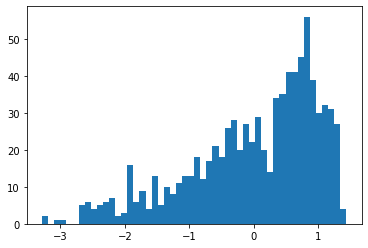

In [13]:
# Need to clean up visibility and depth
test = weather_data['dew']


plt.hist( test , bins = 50)
plt.show()

In [107]:
for col in weather_data: 
    if col =='DATE':
        pass
    else: 
        print(f'{col}: {weather_data[col].std()}')

STATION: 721869337.9650851
Latitudes: 0.1594146823043672
Longitudes: 0.38116964260000996
wind_x: 5.161223793771239
wind_y: 0.5161223793771239
temperature: 3.6060632025978614
pressure: 30.759319915803836
ceiling: 5835.475814824114
visibility: 44617.17355368977
dew: 60.34083959922481
precipitation_duration: 6.3773047198298745
precipitation_depth: 4.804686785225176
mean_aod: 0.10663043793491911
min_aod: 0.11251708428539471
max_aod: 0.11192399832677014
pm25: 6.762957657661695


In [92]:
import numpy as np
a = np.zeros((126, 10, 10))
a.mean(axis=0).shape

(10, 10)